# From Lyrics to Artist
> Duncan Grubbs, Ji Man Kim, Michael Datz

We wanted to train a neural network on the song lyrics from 10 of the most impactful artists. We decided to use 100 songs for each artist. We use the Genius API for gather song data, and then Keras to construct, train, and test our model.

### Libraries, API, and constants setup

In [14]:
# Python Libraries
import os
import json

# Data and preprocessing libraries
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import lyricsgenius as genius
import matplotlib.pylab as plt

# Neural Net Libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, SpatialDropout1D, LSTM
from keras.optimizers import SGD

# Duncan's API key, change to your own if you are downloading data
geniusCreds = 'Lw6NjXtbU7NndUFHRCcOX9FdLhPzVokLIt9c4LWzsTxM10wF7EICGtWSSso8Ohsq'
NUM_OF_SONGS = 100

artist_names = [
    'James Taylor',
    'The Beatles',
    'Johnny Cash',
    'Van Morrison',
    'Bob Dylan',
    'Fleetwood Mac',
    'Lil Wayne',
    'J. Cole',
    'Taylor Swift',
    'Beyoncé'
]

api = genius.Genius(geniusCreds)
genius.skip_non_songs = True
genius.excluded_terms = ["(Remix)", "(Live)"]

### Download Raw Lyric Data

In [ ]:
for artist_name in artist_names:
    artist = api.search_artist(artist_name, max_songs=NUM_OF_SONGS)
    artist.save_lyrics()

### Clean the Data
Remove excess JSON data and write to a new file, just with the lyrics data we need.

In [ ]:
for artist in tqdm(artist_names):
    # remove space from name
    a_mod = artist.replace(' ', '')
    # open raw lyric data
    filename = f'Lyrics_{a_mod}.json'
    with open(f'./data/{filename}') as f:
        data = json.load(f)
        song_obj = {}
        song_obj[artist] = []
        for song in data['songs']:
            song_obj[artist].append(song['lyrics'])
        with open(f'./data/cleaned/{artist}.json', 'w') as outfile:
            json.dump(song_obj, outfile)

### Extract, Tokenize, and One-Hot encode data into X, Y vectors

In [12]:
# get basic X, Y sets for training + testing
# X is song lyrics
# Y is the one-hot encoding of the artists
X = []
Y = []

# active number of artists
NUM_OF_ARTISTS = len(artist_names)
# artist_index_map = {}

def clean_word(word):
    word = word.replace('\n', '')
    word = word.replace('[', '')
    word = word.replace(']', '')
    word = word.replace(':', '')
    return word

for filename in os.listdir('./data/cleaned'):
    with open(f'./data/cleaned/{filename}') as file:
        # ignore macOS files
        if filename == '.DS_Store': continue
        artist_name = filename.replace('.json', '')
        data = json.load(file)[artist_name]
        # ensure we have 100 songs for the artist
        if len(data) == 100:
            for song in data:
                # add the raw song lyrics to the X data
                X.append(song)
                # one hot encode artist
                one_h = np.zeros(NUM_OF_ARTISTS)
                artist_index = artist_names.index(artist_name)
                one_h[artist_index] = 1
                # add the one hot encoding to the Y array
                Y.append(one_h)

# Create map of words to numbers, for tokenizing
word_tokens = {}
for song in X:
    for line in song.split('\n'):
        for word in line.split(' '):
            word = clean_word(word)
            if word not in word_tokens.keys():
                if (len(word_tokens.keys()) == 0):
                    word_tokens[word] = 1
                else:
                    word_tokens[word] = len(word_tokens) + 1
                
# Tokenize the songs in the X vector
# so we are mapping each word to it's key in the big_word_list
token_x = []
for song in X:
    new_song = []
    for line in song.split('\n'):
        for word in line.split(' '):
            word = clean_word(word)
            new_song.append(word_tokens[word])
    token_x.append(np.array(new_song))
X = token_x

# Remove and songs that have fewer than 100 
# words in their lyrics
cutoff = 100
new_x = []
new_y = []
for i in range(0, len(X)):
    if (len(X[i]) >= cutoff):
        new_x.append(X[i])
        new_y.append(Y[i])
X = new_x
Y = new_y

# trim all of the lyrics to 100 words max,
# so the network input in normalized
trimmed = []
for song in X:
    song = song[:100]
    trimmed.append(song)
X = trimmed

# convert to numpy arrays for keras
X = np.array(X)
Y = np.array(Y)

# verify teh X and Y shapes match
print(X.shape)
print(Y.shape)

(971, 100)
(971, 10)


### Create train/test split of X, Y vectors

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(873, 100)
(873, 10)
(98, 100)
(98, 10)


### Create model, train and evaluate

In [21]:
model = Sequential()
model.add(Embedding(len(word_tokens), 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          2608300   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 2,689,710
Trainable params: 2,689,710
Non-trainable params: 0
_________________________________________________________________


In [22]:
epochs = 30
batch_size = 64
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=0)

/Users/duncangrubbs/.pyenv/versions/3.6.1/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [23]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9404
Testing Accuracy:  0.3367


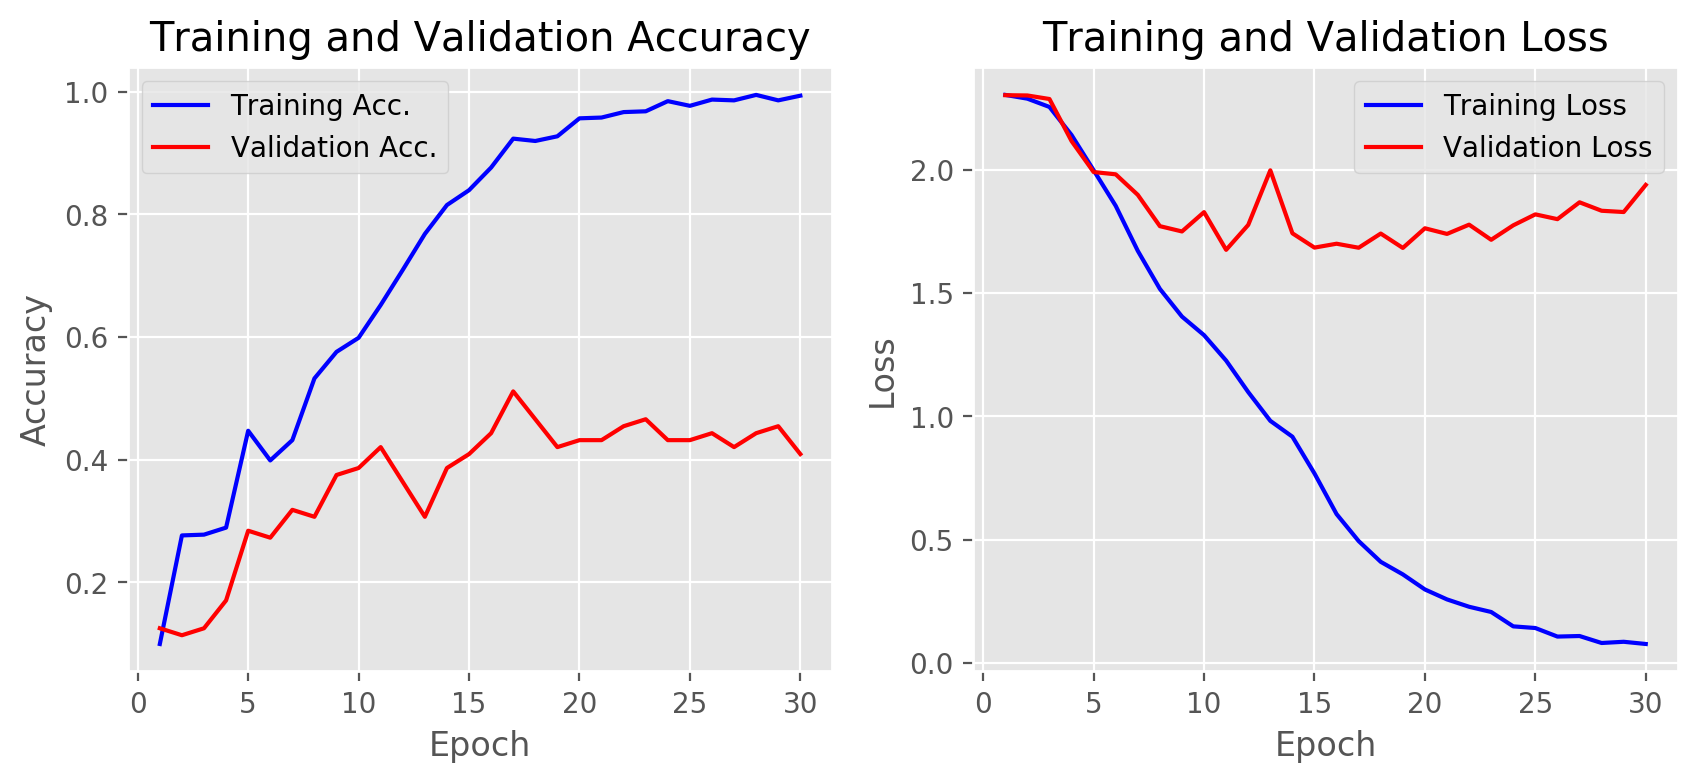

In [40]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)
    
    left.set_xlabel('Epoch')
    left.set_ylabel('Accuracy')
    left.plot(x, acc, 'b', label='Training Acc.')
    left.plot(x, val_acc, 'r', label='Validation Acc.')
    left.set_title('Training and Validation Accuracy')
    left.legend()
    
    right.set_xlabel('Epoch')
    right.set_ylabel('Loss')
    right.plot(x, loss, 'b', label='Training Loss')
    right.plot(x, val_loss, 'r', label='Validation Loss')
    right.set_title('Training and Validation Loss')
    right.legend()
    plt.savefig('network_perf.png')
    
plot_history(history)

### Helper Methods for Visualizations

In [ ]:
def artist_from_output(output):
    index = np.argmax(output)
    return artist_names[index]

def tokenize_text(text):
    tokens = []
    for word in text:
        word = clean_word(word)
        if word in word_tokens.keys():
            tokens.append(word_tokens[word])
        else:
            tokens.append(1)
    tokens = np.array(tokens)
    return tokens

def text_from_tokens(tokens):
    text = []
    for token in tokens:
        index = 0
        for entry in word_tokens.values():
            if token == entry:
                text.append(list(word_tokens.keys())[index])
            index += 1
    return text

In [44]:
for i in range(4):
    print(artist_from_output(Y[i]))
    print(text_from_tokens(X[i][:10]))
    
sample_text = '''
[Intro]
And they wishin' and wishin' and wishin' and wishin'
They wishin' on me, yeah

[Verse 1]
I been movin' calm, don't start no trouble with me
Tryna keep it peaceful is a struggle for me
Don't pull up at 6 AM to cuddle with me
You know how I like it when you lovin' on me
I don't wanna die for them to miss me
Yes, I see the things that they wishin' on me
Hope I got some brothers that outlive me
They gon' tell the story, shit was different with me

[Chorus]
God's plan, God's plan
I hold back, sometimes I won't, yuh
I feel good, sometimes I don't, ayy, don't
I finessed down Weston Road, ayy, 'nessed
Might go down a G.O.D., yeah, wait
I go hard on Southside G, yeah, wait
I make sure that north-side eat

[Post-Chorus]
And still, bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me
Bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me
Yeah, ayy, ayy

[Verse 2]
She say, "Do you love me?" I tell her, "Only partly
I only love my bed and my mama, I'm sorry"
Fifty Dub, I even got it tatted on me
81, they'll bring the crashers to the party
And you know me
Turn the O2 into the O3, dog
Without 40, Oli, there'd be no me
'Magine if I never met the broskies

[Chorus]
God's plan, God's plan
I can't do this on my own, ayy, no, ayy
Someone watchin' this shit close, yep, close
I've been me since Scarlett Road, ayy, road, ayy
Might go down as G.O.D., yeah, wait
I go hard on Southside G, ayy, wait
I make sure that north-side eat, yeah

[Post-Chorus]
And still, bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me, yeah, yeah
Bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me, yeah
'''.split(' ')[:100]

inp = tokenize_text(sample_text)
x_val = np.array([inp])

# output = model.predict(x_val)
# artist_from_output(output)

Taylor Swift
['Verse', '1', 'We', 'could', 'leave', 'the', 'Christmas', 'lights', 'up', "'til"]
Taylor Swift
['Verse', '1', 'I', "don't", 'like', 'your', 'little', 'games', "Don't", 'like']
Taylor Swift
['Chorus', 'Taylor', 'Swift', '&', 'Future', 'I', 'wanna', 'be', 'your', 'end']
Taylor Swift
['Intro', 'Taylor', 'Swift', 'I', 'promise', 'that', "you'll", 'never', 'find', 'another']
